#### RUNPOD ENVIRONMENT SETUP (Run once per pod)

In [2]:
# =============================================================================
# RUNPOD ENVIRONMENT SETUP (Run once per pod)
# =============================================================================

# Clear root filesystem to free space
!rm -rf /root/.cache/huggingface /root/.cache/pip /root/.cache/torch
!pip cache purge
!df -h /

# Remove unused packages to save space
!pip uninstall torchaudio torchvision -y

# Fix typing_extensions compatibility
!pip install --upgrade "typing_extensions>=4.10" --force-reinstall

# Install protobuf and sentencepiece for tokenizers
!pip install protobuf sentencepiece --break-system-packages

# Notebook merging tool
!pip install nbmerge

# PyTorch/CUDA Upgrade (H200 SXM compatibility)
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu124 -q

# Core data science libraries (no dependencies to avoid conflicts)
!pip install -q --no-deps \
    pandas \
    numpy \
    matplotlib \
    seaborn

# ML/NLP libraries
!pip install -q \
    transformers \
    datasets \
    accelerate \
    peft \
    bitsandbytes \
    tqdm

# Evaluation metrics
!pip install -q \
    evaluate \
    rouge-score \
    bert-score \
    textstat \
    sacrebleu \
    git+https://github.com/feralvam/easse.git  # SARI metric (install from GitHub)

# Fix scipy/numpy compatibility
!pip install --upgrade scipy numpy --break-system-packages

# ⚠️ RESTART KERNEL AFTER THIS CELL

Files removed: 0
Filesystem      Size  Used Avail Use% Mounted on
overlay          20G  5.0G   16G  25% /
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip ins

# Chapter 5: Dataset Formatting & Baseline Evaluation

---

## Chapter 5 Overview

This chapter prepares **model-specific instruction datasets** from the ground truth generated in Part 1, and establishes **zero-shot baselines** for all three student models.

### Objectives

1. **Load ground truth data** from Part 1 (labeled_splits.json)
2. **Create model-specific instruction datasets** (ChatML for OpenBioLLM, Mistral format for others)
3. **Define evaluation metrics** (ROUGE-L, SARI, BERTScore, Flesch-Kincaid)
4. **Establish zero-shot baselines** for all three models
5. **Answer research questions** RQ1 and RQ2

---

## Key Design Decision: Format Consistency

| Stage | OpenBioLLM-8B | BioMistral / Mistral-7B |
|-------|---------------|-------------------------|
| Dataset Creation (5.3) | ChatML | Mistral |
| Training (6.x) | ChatML | Mistral |
| Baseline Eval (5.9) | ChatML | Mistral |
| Post-FT Eval (7.x) | ChatML | Mistral |

**Rationale:** Models trained and evaluated with their native format for optimal performance.

---

## Research Questions Addressed

| RQ | Question | Section |
|----|----------|---------|
| **RQ1** | Does medical pretraining help zero-shot simplification? | 5.10 |
| **RQ2** | Which model is best at zero-shot? | 5.10 |

---

## Section 5.1: Setup & Configuration

Configure environment, paths, and model definitions.

---

In [18]:
# =============================================================================
# SECTION 5.1: SETUP & CONFIGURATION
# =============================================================================

# Import os module for environment variable manipulation and file system operations
import os
# Import Path class for object-oriented filesystem path handling
from pathlib import Path

# -----------------------------------------------------------------------------
# HuggingFace Cache Configuration (MUST be set BEFORE importing transformers)
# Redirect all caches to /workspace (persistent disk on RunPod)
# -----------------------------------------------------------------------------

# Define the root directory for the project on RunPod's persistent storage
PROJECT_ROOT = Path("/workspace/medisimplifier")
# Define the directory where HuggingFace models and datasets will be cached
HF_CACHE_DIR = Path("/workspace/HFModels")

# Set HF_HOME environment variable to redirect HuggingFace's main cache directory
os.environ["HF_HOME"] = "/workspace/HFModels"
# Set HF_DATASETS_CACHE to store downloaded datasets in the cache directory
os.environ["HF_DATASETS_CACHE"] = str(HF_CACHE_DIR / "datasets")
# Set HUGGINGFACE_HUB_CACHE to store model files from HuggingFace Hub
os.environ["HUGGINGFACE_HUB_CACHE"] = str(HF_CACHE_DIR / "hub")
# Set PIP_CACHE_DIR to store pip packages on persistent storage
os.environ["PIP_CACHE_DIR"] = "/workspace/pip_cache"
# Set TMPDIR to use persistent storage for temporary files
os.environ["TMPDIR"] = "/workspace/tmp"

# Create the HuggingFace cache directory if it doesn't exist (with parents)
HF_CACHE_DIR.mkdir(parents=True, exist_ok=True)
# Create the pip cache directory if it doesn't exist
Path("/workspace/pip_cache").mkdir(parents=True, exist_ok=True)
# Create the temporary directory if it doesn't exist
Path("/workspace/tmp").mkdir(parents=True, exist_ok=True)

# -----------------------------------------------------------------------------
# Standard Library Imports
# -----------------------------------------------------------------------------

# Import sys for system-specific parameters and functions
import sys
# Import json for reading/writing JSON files (dataset storage)
import json
# Import random for reproducible random operations
import random
# Import warnings to suppress unnecessary warning messages
import warnings
# Import datetime for timestamping checkpoints and results
from datetime import datetime
# Import type hints for function signatures and documentation
from typing import Dict, List, Optional, Tuple, Any
# Import time for measuring execution duration
import time
# Import gc (garbage collector) for manual memory management
import gc

# -----------------------------------------------------------------------------
# Data Science Libraries
# -----------------------------------------------------------------------------

# Import numpy for numerical operations and array manipulation
import numpy as np
# Import pandas for tabular data manipulation and CSV operations
import pandas as pd

# -----------------------------------------------------------------------------
# Visualization Libraries
# -----------------------------------------------------------------------------

# Import matplotlib.pyplot for creating charts and figures
import matplotlib.pyplot as plt
# Import seaborn for enhanced statistical visualizations
import seaborn as sns

# -----------------------------------------------------------------------------
# PyTorch
# -----------------------------------------------------------------------------

# Configure GPU ID for this execution
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set GPU: "0", "1", or "2"

# Import PyTorch for deep learning operations and GPU management
import torch
# Import neural network module (not used directly but commonly needed)
import torch.nn as nn

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
print(f"✅ CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
# -----------------------------------------------------------------------------
# HuggingFace Transformers
# -----------------------------------------------------------------------------

# Import AutoTokenizer for loading model-specific tokenizers automatically
# Import AutoModelForCausalLM for loading causal language models (GPT-style)
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
# Import snapshot_download to pre-download models before loading
from huggingface_hub import snapshot_download

# -----------------------------------------------------------------------------
# HuggingFace Datasets
# -----------------------------------------------------------------------------

# Import load_dataset for loading datasets from HuggingFace Hub
# Import load_from_disk for loading locally saved datasets
# Import Dataset class for creating custom datasets
# Import DatasetDict for organizing train/val/test splits
from datasets import (
    load_dataset,
    load_from_disk,
    Dataset,
    DatasetDict,
)

# -----------------------------------------------------------------------------
# Evaluation Libraries
# -----------------------------------------------------------------------------

# Import evaluate for loading standardized NLP metrics
import evaluate
# Import textstat for computing readability metrics (Flesch-Kincaid)
import textstat
# Import rouge_scorer as backup for ROUGE computation
from rouge_score import rouge_scorer

# -----------------------------------------------------------------------------
# Progress Bar
# -----------------------------------------------------------------------------

# Import tqdm for displaying progress bars during long operations
from tqdm.auto import tqdm

# Suppress all warning messages to keep output clean
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# Random Seed Configuration
# -----------------------------------------------------------------------------

# Define global random seed for reproducibility across all experiments
SEED = 42
# Set Python's random module seed
random.seed(SEED)
# Set NumPy's random seed for array operations
np.random.seed(SEED)
# Set PyTorch's random seed for CPU operations
torch.manual_seed(SEED)

# Check if CUDA (GPU) is available for additional seed configuration
if torch.cuda.is_available():
    # Set random seed for all GPU devices
    torch.cuda.manual_seed_all(SEED)
    # Enable deterministic mode for reproducible results
    torch.backends.cudnn.deterministic = True
    # Disable benchmark mode which can cause non-determinism
    torch.backends.cudnn.benchmark = False

# Print section header for logging
print("=" * 70)
print("SECTION 5.1: SETUP & CONFIGURATION")
print("=" * 70)

# Print confirmation of successful imports
print(f"\n📦 5.1.1 Imports:")
print(f"   ✓ All libraries imported successfully")
print(f"   ✓ Random seed set to: {SEED}")
print(f"   ✓ PyTorch version: {torch.__version__}")
print(f"   ✓ CUDA available: {torch.cuda.is_available()}")
# Print GPU information if available
if torch.cuda.is_available():
    print(f"   ✓ CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"   ✓ CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# -----------------------------------------------------------------------------
# Directory Configuration
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 5.1.2 Directory Configuration:")

# Define directory for storing processed datasets
DATA_DIR = PROJECT_ROOT / "data"
# Define directory for storing trained model checkpoints
MODELS_DIR = PROJECT_ROOT / "models"
# Define directory for storing evaluation results and metrics
RESULTS_DIR = PROJECT_ROOT / "results"
# Define directory for storing training checkpoints
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints"
# Define directory for storing training logs
LOGS_DIR = PROJECT_ROOT / "logs"
# Define directory for storing generated figures and plots
FIGURES_DIR = RESULTS_DIR / "figures"
# Define directory for storing baseline evaluation results
BASELINE_DIR = RESULTS_DIR / "baseline"

# Create list of all directories that need to exist
ALL_DIRS = [
    PROJECT_ROOT, DATA_DIR, MODELS_DIR, RESULTS_DIR,
    CHECKPOINTS_DIR, LOGS_DIR, FIGURES_DIR, BASELINE_DIR, HF_CACHE_DIR
]

# Create each directory if it doesn't exist (including parent directories)
for directory in ALL_DIRS:
    directory.mkdir(parents=True, exist_ok=True)

# Print confirmation of directory paths
print(f"   ✓ Project root: {PROJECT_ROOT}")
print(f"   ✓ Data directory: {DATA_DIR}")
print(f"   ✓ Results directory: {RESULTS_DIR}")
print(f"   ✓ Baseline directory: {BASELINE_DIR}")
print(f"   ✓ HuggingFace cache: {HF_CACHE_DIR}")

# -----------------------------------------------------------------------------
# Model Configurations
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 5.1.3 Model Configurations:")

# Define configuration dictionary for all three student models
# Each model has: HuggingFace path, architecture, prompt format, type, LoRA targets, parameter count
STUDENT_MODELS = {
    # OpenBioLLM-8B: Medical LLM based on Llama3 architecture, uses ChatML format
    "OpenBioLLM-8B": {
        "path": "aaditya/Llama3-OpenBioLLM-8B",  # HuggingFace model path
        "architecture": "llama3",  # Base architecture type
        "prompt_format": "chatml",  # Prompt template format to use
        "type": "Medical",  # Model domain type for RQ analysis
        "target_modules": ["q_proj", "v_proj"],  # LoRA target modules
        "parameters": "8B",  # Model parameter count
    },
    # BioMistral-7B-DARE: Medical LLM based on Mistral architecture
    "BioMistral-7B-DARE": {
        "path": "BioMistral/BioMistral-7B-DARE",  # HuggingFace model path
        "architecture": "mistral",  # Base architecture type
        "prompt_format": "mistral",  # Prompt template format to use
        "type": "Medical",  # Model domain type for RQ analysis
        "target_modules": ["q_proj", "v_proj"],  # LoRA target modules
        "parameters": "7B",  # Model parameter count
    },
    # Mistral-7B: General-purpose LLM (control/baseline for medical comparison)
    "Mistral-7B": {
        "path": "mistralai/Mistral-7B-Instruct-v0.2",  # HuggingFace model path
        "architecture": "mistral",  # Base architecture type
        "prompt_format": "mistral",  # Prompt template format to use
        "type": "General",  # Model domain type for RQ analysis
        "target_modules": ["q_proj", "v_proj"],  # LoRA target modules
        "parameters": "7B",  # Model parameter count
    },
}

# Print configuration summary for each model
for name, config in STUDENT_MODELS.items():
    print(f"   ✓ {name}: {config['architecture']} / {config['prompt_format']} format / {config['type']}")

# -----------------------------------------------------------------------------
# TASK_INSTRUCTION (Part 2 Only - Training & Inference)
# Note: SIMPLIFICATION_INSTRUCTION is Part 1 only (Claude API ground truth)
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 5.1.4 Task Instruction (Part 2):")

# Define the task instruction prompt used for training and inference
# This is the same instruction given to student models during training and evaluation
# Note: Different from SIMPLIFICATION_INSTRUCTION used in Part 1 for Claude API
TASK_INSTRUCTION = """Simplify the following medical discharge summary in plain language for patients with no medical background.
Guidelines:
- Replace medical jargon with everyday words (e.g., "hypertension" → "high blood pressure")
- Keep all important information (diagnoses, medications, follow-up instructions)
- Use short, clear sentences (aim for 15-20 words per sentence)
- Aim for a 6th-grade reading level
- Maintain the same structure as the original
- Do not add or omit information
- Keep the same patient reference style (e.g., "The patient" stays "The patient", not "You")
- Output plain text only (no markdown, no bold, no headers, no bullet points)
- Do not include empty lines or separator characters like "---\""""

# Print confirmation of instruction definition
print(f"   ✓ TASK_INSTRUCTION defined ({len(TASK_INSTRUCTION)} chars)")

# -----------------------------------------------------------------------------
# Prompt Templates (Model-Specific)
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 5.1.5 Prompt Templates:")

# ChatML Training Template for OpenBioLLM-8B
# Format: <|im_start|>role\ncontent<|im_end|>
# Used during fine-tuning to format input-output pairs
# Includes system message to properly guide model behavior
CHATML_TEMPLATE = """<|im_start|>system
You are a helpful medical assistant that simplifies complex medical text for patients.<|im_end|>
<|im_start|>user
{instruction}

{input}<|im_end|>
<|im_start|>assistant
{output}<|im_end|>"""

# ChatML Inference Template for OpenBioLLM-8B
# Same as training but without the output (model generates it)
# Includes system message to properly guide model behavior
CHATML_INFERENCE_TEMPLATE = """<|im_start|>system
You are a helpful medical assistant that simplifies complex medical text for patients.<|im_end|>
<|im_start|>user
{instruction}

{input}<|im_end|>
<|im_start|>assistant
"""

# Mistral Training Template for BioMistral and Mistral-7B
# Format: <<SYS>> system message <</SYS>> [INST] instruction input [/INST]output
# Used during fine-tuning to format input-output pairs
# Includes system message to properly guide model behavior
MISTRAL_TEMPLATE = """[INST] <<SYS>>
You are a helpful medical assistant that simplifies complex medical text for patients.
<</SYS>>

{instruction}

{input} [/INST]{output}"""

# Mistral Inference Template for BioMistral and Mistral-7B
# Same as training but without the output (model generates it)
# Includes system message to properly guide model behavior
MISTRAL_INFERENCE_TEMPLATE = """[INST] <<SYS>>
You are a helpful medical assistant that simplifies complex medical text for patients.
<</SYS>>

{instruction}

{input} [/INST]"""

# Print confirmation of template definitions
print(f"   ✓ CHATML_TEMPLATE defined (training)")
print(f"   ✓ CHATML_INFERENCE_TEMPLATE defined (inference)")
print(f"   ✓ MISTRAL_TEMPLATE defined (training)")
print(f"   ✓ MISTRAL_INFERENCE_TEMPLATE defined (inference)")

# Create mapping from format name to training template
# Used by format_training_example() to select correct template
TRAINING_TEMPLATES = {
    "chatml": CHATML_TEMPLATE,  # OpenBioLLM-8B uses ChatML
    "mistral": MISTRAL_TEMPLATE,  # BioMistral and Mistral-7B use Mistral format
}

# Create mapping from format name to inference template
# Used by format_inference_prompt() to select correct template
INFERENCE_TEMPLATES = {
    "chatml": CHATML_INFERENCE_TEMPLATE,  # OpenBioLLM-8B uses ChatML
    "mistral": MISTRAL_INFERENCE_TEMPLATE,  # BioMistral and Mistral-7B use Mistral format
}

# -----------------------------------------------------------------------------
# Evaluation Configuration
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 5.1.6 Evaluation Configuration:")

# Maximum number of new tokens to generate during inference
# 512 is sufficient for simplified discharge summaries
MAX_NEW_TOKENS = 512
# Batch size for evaluation (1 for sequential generation to avoid OOM)
EVAL_BATCH_SIZE = 1

# Print configuration values
print(f"   ✓ Max new tokens: {MAX_NEW_TOKENS}")
print(f"   ✓ Evaluation batch size: {EVAL_BATCH_SIZE}")

# -----------------------------------------------------------------------------
# Helper Functions
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 5.1.7 Helper Functions:")

def clear_memory():
    """
    Clear GPU memory to prevent OOM errors when loading multiple models.
    Should be called after deleting model objects.
    """
    # Run Python garbage collector to free unreferenced objects
    gc.collect()
    # Check if CUDA is available before attempting GPU operations
    if torch.cuda.is_available():
        # Empty the CUDA cache to free GPU memory
        torch.cuda.empty_cache()
        # Synchronize CUDA operations to ensure memory is freed
        torch.cuda.synchronize()

def print_gpu_memory():
    """
    Print current GPU memory usage for monitoring.
    Useful for debugging OOM issues during training/inference.
    """
    # Check if CUDA is available before attempting GPU operations
    if torch.cuda.is_available():
        # Get currently allocated GPU memory in bytes, convert to GB
        allocated = torch.cuda.memory_allocated() / 1e9
        # Get reserved GPU memory (includes fragmentation) in bytes, convert to GB
        reserved = torch.cuda.memory_reserved() / 1e9
        # Print formatted memory usage
        print(f"   GPU Memory: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")

def format_inference_prompt(instruction: str, input_text: str, prompt_format: str) -> str:
    """
    Format a prompt for inference using the model-specific template.
    
    Args:
        instruction: The task instruction (TASK_INSTRUCTION)
        input_text: The complex medical text to simplify
        prompt_format: Either 'chatml' or 'mistral'
    
    Returns:
        Formatted prompt string ready for tokenization
    """
    # Look up the appropriate inference template based on format
    template = INFERENCE_TEMPLATES[prompt_format]
    # Fill in the template placeholders with actual values
    return template.format(instruction=instruction, input=input_text)

def format_training_example(instruction: str, input_text: str, output: str, prompt_format: str) -> str:
    """
    Format a training example using the model-specific template.
    
    Args:
        instruction: The task instruction (TASK_INSTRUCTION)
        input_text: The complex medical text (input)
        output: The simplified text (target output)
        prompt_format: Either 'chatml' or 'mistral'
    
    Returns:
        Formatted training example string with input and output
    """
    # Look up the appropriate training template based on format
    template = TRAINING_TEMPLATES[prompt_format]
    # Fill in the template placeholders with actual values
    return template.format(instruction=instruction, input=input_text, output=output)

# Print confirmation of helper function definitions
print(f"   ✓ clear_memory()")
print(f"   ✓ print_gpu_memory()")
print(f"   ✓ format_inference_prompt()")
print(f"   ✓ format_training_example()")

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.1 COMPLETE")
print("=" * 70)

✅ PyTorch: 2.6.0+cu124
✅ CUDA available: True
✅ CUDA version: 12.4
✅ GPU: NVIDIA H200
✅ GPU Memory: 150.1 GB
SECTION 5.1: SETUP & CONFIGURATION

📦 5.1.1 Imports:
   ✓ All libraries imported successfully
   ✓ Random seed set to: 42
   ✓ PyTorch version: 2.6.0+cu124
   ✓ CUDA available: True
   ✓ CUDA device: NVIDIA H200
   ✓ CUDA memory: 150.1 GB

📦 5.1.2 Directory Configuration:
   ✓ Project root: /workspace/medisimplifier
   ✓ Data directory: /workspace/medisimplifier/data
   ✓ Results directory: /workspace/medisimplifier/results
   ✓ Baseline directory: /workspace/medisimplifier/results/baseline
   ✓ HuggingFace cache: /workspace/HFModels

📦 5.1.3 Model Configurations:
   ✓ OpenBioLLM-8B: llama3 / chatml format / Medical
   ✓ BioMistral-7B-DARE: mistral / mistral format / Medical
   ✓ Mistral-7B: mistral / mistral format / General

📦 5.1.4 Task Instruction (Part 2):
   ✓ TASK_INSTRUCTION defined (707 chars)

📦 5.1.5 Prompt Templates:
   ✓ CHATML_TEMPLATE defined (training)
   ✓ CHATM

## Section 5.2: Load Ground Truth Data (from Part 1)

Load the labeled splits generated in Part 1 containing (complex_text, simplified_text) pairs.

---

In [19]:
# =============================================================================
# SECTION 5.2: LOAD GROUND TRUTH DATA (FROM PART 1)
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.2: LOAD GROUND TRUTH DATA")
print("=" * 70)

# Define path to the labeled splits JSON file created in Part 1
# This file contains train/val/test splits with Claude-generated ground truth
LABELED_SPLITS_PATH = DATA_DIR / "labeled_splits.json"

# Print the path being loaded
print(f"\n📂 Loading ground truth from: {LABELED_SPLITS_PATH}")

# Check if the ground truth file exists, raise error if not
if not LABELED_SPLITS_PATH.exists():
    # Provide helpful error message with instructions
    raise FileNotFoundError(
        f"Ground truth file not found at {LABELED_SPLITS_PATH}. "
        f"Please run Part 1 first or upload the labeled_splits.json file."
    )

# Open and load the JSON file containing labeled splits
with open(LABELED_SPLITS_PATH, "r", encoding="utf-8") as f:
    # Parse JSON content into Python dictionary
    labeled_splits = json.load(f)

# Extract training data list from the labeled splits dictionary
train_data = labeled_splits["train"]
# Extract validation data list from the labeled splits dictionary
val_data = labeled_splits["validation"]
# Extract test data list from the labeled splits dictionary
test_data = labeled_splits["test"]

# Print statistics about loaded data
print(f"\n📊 Ground Truth Statistics:")
print(f"   ✓ Train samples: {len(train_data):,}")
print(f"   ✓ Validation samples: {len(val_data):,}")
print(f"   ✓ Test samples: {len(test_data):,}")
# Calculate and print total sample count
print(f"   ✓ Total samples: {len(train_data) + len(val_data) + len(test_data):,}")

# Get first sample to verify data structure
sample = train_data[0]
# Print sample structure information
print(f"\n📋 Sample Structure:")
# Print the keys present in each sample dictionary
print(f"   Keys: {list(sample.keys())}")
# Print length of complex text (input), handling both key naming conventions
print(f"   Complex text length: {len(sample.get('complex_text', sample.get('input', '')))} chars")
# Print length of simplified text (output), handling both key naming conventions
print(f"   Simplified text length: {len(sample.get('simplified_text', sample.get('output', '')))} chars")

def normalize_sample(sample: Dict) -> Dict:
    """
    Normalize sample field names for consistency across the codebase.
    Part 1 may use 'input'/'output' while Part 2 uses 'complex_text'/'simplified_text'.
    
    Args:
        sample: Dictionary with either naming convention
    
    Returns:
        Dictionary with standardized 'complex_text' and 'simplified_text' keys
    """
    # Create normalized dictionary with consistent key names
    return {
        # Try 'complex_text' first, fall back to 'input' if not found
        "complex_text": sample.get("complex_text", sample.get("input", "")),
        # Try 'simplified_text' first, fall back to 'output' if not found
        "simplified_text": sample.get("simplified_text", sample.get("output", "")),
    }

# Apply normalization to all training samples using list comprehension
train_data = [normalize_sample(s) for s in train_data]
# Apply normalization to all validation samples
val_data = [normalize_sample(s) for s in val_data]
# Apply normalization to all test samples
test_data = [normalize_sample(s) for s in test_data]

# Print confirmation of successful normalization
print(f"\n✅ Ground truth data loaded and normalized")

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.2 COMPLETE")
print("=" * 70)

SECTION 5.2: LOAD GROUND TRUTH DATA

📂 Loading ground truth from: /workspace/medisimplifier/data/labeled_splits.json

📊 Ground Truth Statistics:
   ✓ Train samples: 7,999
   ✓ Validation samples: 999
   ✓ Test samples: 1,001
   ✓ Total samples: 9,999

📋 Sample Structure:
   Keys: ['split', 'index', 'sample_key', 'complex_text', 'simplified_text', 'input_tokens', 'output_tokens']
   Complex text length: 1401 chars
   Simplified text length: 1577 chars

✅ Ground truth data loaded and normalized

✅ SECTION 5.2 COMPLETE


## Section 5.3: Create Instruction Datasets (Model-Specific)

Create model-specific instruction datasets using:
- **ChatML format** for OpenBioLLM-8B
- **Mistral format** for BioMistral-7B-DARE and Mistral-7B

All datasets use `TASK_INSTRUCTION` (not `SIMPLIFICATION_INSTRUCTION` which is Part 1 only).

---

In [ ]:
# =============================================================================
# SECTION 5.3: CREATE INSTRUCTION DATASETS (MODEL-SPECIFIC)
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.3: CREATE INSTRUCTION DATASETS (MODEL-SPECIFIC)")
print("=" * 70)

def create_instruction_dataset(
    data: List[Dict],
    prompt_format: str,
    split_name: str
) -> Dataset:
    """
    Create a HuggingFace Dataset with model-specific formatting.
    
    This function takes raw data samples and formats them according to
    the specified prompt format (ChatML or Mistral) for training.
    
    Args:
        data: List of dictionaries with 'complex_text' and 'simplified_text' keys
        prompt_format: Either 'chatml' (OpenBioLLM) or 'mistral' (BioMistral, Mistral-7B)
        split_name: Name of the split ('train', 'validation', or 'test') for logging
    
    Returns:
        HuggingFace Dataset with formatted examples ready for training
    """
    # Initialize empty list to store formatted examples
    formatted_examples = []
    
    # Iterate through each sample with progress bar
    for sample in tqdm(data, desc=f"Formatting {split_name} ({prompt_format})", leave=False):
        # Extract complex text (input) from sample
        complex_text = sample["complex_text"]
        # Extract simplified text (target output) from sample
        simplified_text = sample["simplified_text"]
        
        # Create formatted text using model-specific template
        # This combines instruction, input, and output into the correct format
        formatted_text = format_training_example(
            instruction=TASK_INSTRUCTION,  # Use Part 2 task instruction
            input_text=complex_text,  # Complex medical text
            output=simplified_text,  # Claude-generated simplified text
            prompt_format=prompt_format  # 'chatml' or 'mistral'
        )
        
        # Create example dictionary with all relevant fields
        formatted_examples.append({
            "instruction": TASK_INSTRUCTION,  # Store instruction separately
            "input": complex_text,  # Store input separately
            "output": simplified_text,  # Store output separately
            "text": formatted_text,  # Pre-formatted text for training
            "prompt_format": prompt_format,  # Track which format was used
        })
    
    # Convert list of dictionaries to HuggingFace Dataset object
    return Dataset.from_list(formatted_examples)

# -----------------------------------------------------------------------------
# Create ChatML Dataset (for OpenBioLLM-8B)
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 Creating ChatML Dataset (OpenBioLLM-8B):")

# Create ChatML-formatted training dataset
chatml_train = create_instruction_dataset(train_data, "chatml", "train")
# Create ChatML-formatted validation dataset
chatml_val = create_instruction_dataset(val_data, "chatml", "validation")
# Create ChatML-formatted test dataset
chatml_test = create_instruction_dataset(test_data, "chatml", "test")

# Combine all splits into a DatasetDict for organized access
chatml_dataset = DatasetDict({
    "train": chatml_train,  # Training split
    "validation": chatml_val,  # Validation split for hyperparameter tuning
    "test": chatml_test,  # Test split for final evaluation
})

# Print sample counts for each split
print(f"   ✓ Train: {len(chatml_train):,} samples")
print(f"   ✓ Validation: {len(chatml_val):,} samples")
print(f"   ✓ Test: {len(chatml_test):,} samples")

# -----------------------------------------------------------------------------
# Create Mistral Dataset (for BioMistral-7B-DARE and Mistral-7B)
# -----------------------------------------------------------------------------

# Print subsection header
print(f"\n📦 Creating Mistral Dataset (BioMistral, Mistral-7B):")

# Create Mistral-formatted training dataset
mistral_train = create_instruction_dataset(train_data, "mistral", "train")
# Create Mistral-formatted validation dataset
mistral_val = create_instruction_dataset(val_data, "mistral", "validation")
# Create Mistral-formatted test dataset
mistral_test = create_instruction_dataset(test_data, "mistral", "test")

# Combine all splits into a DatasetDict for organized access
mistral_dataset = DatasetDict({
    "train": mistral_train,  # Training split
    "validation": mistral_val,  # Validation split for hyperparameter tuning
    "test": mistral_test,  # Test split for final evaluation
})

# Print sample counts for each split
print(f"   ✓ Train: {len(mistral_train):,} samples")
print(f"   ✓ Validation: {len(mistral_val):,} samples")
print(f"   ✓ Test: {len(mistral_test):,} samples")

# -----------------------------------------------------------------------------
# Verify Format Samples
# -----------------------------------------------------------------------------

# Print verification header
print(f"\n📋 Sample Verification:")

# Print first 500 characters of a ChatML-formatted sample for visual verification
print(f"\n--- ChatML Format Sample (first 500 chars) ---")
print(chatml_train[0]["text"][:500])
print("...")

# Print first 500 characters of a Mistral-formatted sample for visual verification
print(f"\n--- Mistral Format Sample (first 500 chars) ---")
print(mistral_train[0]["text"][:500])
print("...")

# Store datasets in a dictionary for easy access by format name
# Used in Chapter 6 for training the appropriate models
INSTRUCTION_DATASETS = {
    "chatml": chatml_dataset,  # For OpenBioLLM-8B
    "mistral": mistral_dataset,  # For BioMistral and Mistral-7B
}

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.3 COMPLETE")
print("=" * 70)

## Section 5.4: Save Instruction Datasets

Save model-specific instruction datasets to disk for use in Chapter 6.

---

In [ ]:
# =============================================================================
# SECTION 5.4: SAVE INSTRUCTION DATASETS
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.4: SAVE INSTRUCTION DATASETS")
print("=" * 70)

# Define root directory for instruction datasets
INSTRUCTION_DATASET_DIR = DATA_DIR / "instruction_dataset"
# Create the directory if it doesn't exist
INSTRUCTION_DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Define path for ChatML-formatted dataset
chatml_path = INSTRUCTION_DATASET_DIR / "chatml"
# Save ChatML dataset to disk using HuggingFace's efficient Arrow format
chatml_dataset.save_to_disk(str(chatml_path))
# Print confirmation of save location
print(f"\n📁 Saved ChatML dataset to: {chatml_path}")

# Define path for Mistral-formatted dataset
mistral_path = INSTRUCTION_DATASET_DIR / "mistral"
# Save Mistral dataset to disk using HuggingFace's efficient Arrow format
mistral_dataset.save_to_disk(str(mistral_path))
# Print confirmation of save location
print(f"📁 Saved Mistral dataset to: {mistral_path}")

# Create metadata dictionary documenting the saved datasets
dataset_info = {
    "created_at": datetime.now().isoformat(),  # Timestamp of creation
    "formats": ["chatml", "mistral"],  # Available format types
    "splits": ["train", "validation", "test"],  # Available data splits
    "samples": {  # Sample counts per split
        "train": len(train_data),
        "validation": len(val_data),
        "test": len(test_data),
    },
    "task_instruction_length": len(TASK_INSTRUCTION),  # Instruction length for reference
    "model_format_mapping": {  # Document which model uses which format
        "OpenBioLLM-8B": "chatml",
        "BioMistral-7B-DARE": "mistral",
        "Mistral-7B": "mistral",
    },
}

# Define path for dataset metadata JSON file
info_path = INSTRUCTION_DATASET_DIR / "dataset_info.json"
# Save metadata to JSON file
with open(info_path, "w", encoding="utf-8") as f:
    json.dump(dataset_info, f, indent=2)  # Pretty-print with 2-space indent
# Print confirmation of metadata save
print(f"📁 Saved dataset info to: {info_path}")

# Print summary of saved datasets
print(f"\n📊 Dataset Summary:")
# Iterate through each format and print split counts
for fmt, ds in INSTRUCTION_DATASETS.items():
    print(f"   {fmt}: {len(ds['train']):,} train, {len(ds['validation']):,} val, {len(ds['test']):,} test")

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.4 COMPLETE")
print("=" * 70)

## Section 5.5: Load Test Data

Prepare test data for baseline evaluation.

---

In [20]:
# =============================================================================
# SECTION 5.5: LOAD TEST DATA
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.5: LOAD TEST DATA")
print("=" * 70)

# Note: Test data was already loaded in Section 5.2
# This section prepares it specifically for baseline evaluation

# Print test data statistics
print(f"\n📊 Test Data for Baseline Evaluation:")
print(f"   ✓ Total test samples: {len(test_data):,}")

# Create list of test samples with indices for tracking
# Each sample includes: index, complex text (input), and reference (ground truth)
test_samples = []
# Iterate through test data with enumeration for indexing
for i, sample in enumerate(test_data):
    test_samples.append({
        "idx": i,  # Index for tracking and reference
        "complex_text": sample["complex_text"],  # Input to simplify
        "reference": sample["simplified_text"],  # Ground truth (Claude output)
    })

# Print confirmation of preparation
print(f"   ✓ Test samples prepared with references")

# Compute Flesch-Kincaid grade level for all reference texts
# This establishes the target reading level from Claude's outputs
reference_fk_grades = [
    textstat.flesch_kincaid_grade(sample["reference"])  # Compute FK grade
    for sample in test_samples  # For each test sample
]
# Calculate mean FK grade across all references
reference_fk_mean = np.mean(reference_fk_grades)
# Calculate standard deviation of FK grades
reference_fk_std = np.std(reference_fk_grades)

# Print reference statistics for comparison with model outputs
print(f"\n📊 Reference (Ground Truth) Statistics:")
print(f"   ✓ FK Grade Mean: {reference_fk_mean:.2f}")
print(f"   ✓ FK Grade Std: {reference_fk_std:.2f}")
print(f"   ✓ FK Grade Range: [{min(reference_fk_grades):.2f}, {max(reference_fk_grades):.2f}]")

# Store reference statistics in a dictionary for later use
# Used in baseline comparison and research question analysis
REFERENCE_STATS = {
    "fk_mean": reference_fk_mean,  # Mean Flesch-Kincaid grade
    "fk_std": reference_fk_std,  # Standard deviation
    "fk_min": min(reference_fk_grades),  # Minimum grade level
    "fk_max": max(reference_fk_grades),  # Maximum grade level
    "n_samples": len(test_samples),  # Total sample count
}

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.5 COMPLETE")
print("=" * 70)

SECTION 5.5: LOAD TEST DATA

📊 Test Data for Baseline Evaluation:
   ✓ Total test samples: 1,001
   ✓ Test samples prepared with references

📊 Reference (Ground Truth) Statistics:
   ✓ FK Grade Mean: 7.23
   ✓ FK Grade Std: 1.31
   ✓ FK Grade Range: [3.43, 16.27]

✅ SECTION 5.5 COMPLETE


## Section 5.6: Define Evaluation Metrics

Define the evaluation metrics:
- **ROUGE-L**: Longest common subsequence overlap
- **SARI**: Simplification quality (add, keep, delete operations)
- **BERTScore**: Semantic similarity using BERT embeddings
- **Flesch-Kincaid**: Reading grade level (target ≤ 6)

---

In [21]:
# =============================================================================
# SECTION 5.6: DEFINE EVALUATION METRICS
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.6: DEFINE EVALUATION METRICS")
print("=" * 70)

# -----------------------------------------------------------------------------
# Load Evaluation Metrics
# -----------------------------------------------------------------------------

# Print loading status
print(f"\n📦 Loading evaluation metrics...")

# Load ROUGE metric from HuggingFace evaluate library
# ROUGE-L measures longest common subsequence between prediction and reference
rouge_metric = evaluate.load("rouge")
print(f"   ✓ ROUGE metric loaded")

# Load BERTScore metric from HuggingFace evaluate library
# BERTScore measures semantic similarity using contextual embeddings
bertscore_metric = evaluate.load("bertscore")
print(f"   ✓ BERTScore metric loaded")

# Load SARI metric from HuggingFace evaluate library
# SARI (System output Against References and against the Input)
# Specifically designed for text simplification evaluation
sari_metric = evaluate.load("sari")
print(f"   ✓ SARI metric loaded")

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------

def compute_metrics(
    predictions: List[str],
    references: List[str],
    sources: List[str],
    compute_bertscore: bool = True
) -> Dict[str, float]:
    """
    Compute all evaluation metrics for simplification quality.
    
    Args:
        predictions: List of model-generated simplified texts
        references: List of ground truth simplified texts (from Claude)
        sources: List of original complex medical texts
        compute_bertscore: Whether to compute BERTScore (slower, GPU-intensive)
    
    Returns:
        Dictionary containing all metric scores and statistics
    """
    # Initialize empty metrics dictionary
    metrics = {}
    
    # Filter out samples with empty predictions (model failures)
    # Get indices of valid (non-empty) predictions
    valid_indices = [i for i, p in enumerate(predictions) if p.strip()]
    # Extract valid predictions using filtered indices
    valid_predictions = [predictions[i] for i in valid_indices]
    # Extract corresponding references
    valid_references = [references[i] for i in valid_indices]
    # Extract corresponding source texts
    valid_sources = [sources[i] for i in valid_indices]
    
    # Handle edge case where all predictions are empty
    if len(valid_predictions) == 0:
        # Return default/penalty values for all metrics
        return {
            "ROUGE-L": 0.0,  # Zero overlap
            "SARI": 0.0,  # Zero simplification quality
            "BERTScore-F1": 0.0,  # Zero semantic similarity
            "FK-Grade-Mean": 15.0,  # Penalty grade level (very high)
            "FK-Grade-Std": 0.0,  # No variation
            "valid_samples": 0,  # No valid samples
            "total_samples": len(predictions),  # Track total attempted
        }
    
    # Compute ROUGE-L score (longest common subsequence)
    rouge_results = rouge_metric.compute(
        predictions=valid_predictions,  # Model outputs
        references=valid_references,  # Ground truth
        use_stemmer=True  # Use Porter stemmer for better matching
    )
    # Extract ROUGE-L F1 score and convert to float
    metrics["ROUGE-L"] = float(rouge_results["rougeL"])
    
    # Compute SARI score (simplification-specific metric)
    # SARI requires sources to compute add/keep/delete operations
    sari_results = sari_metric.compute(
        sources=valid_sources,  # Original complex texts
        predictions=valid_predictions,  # Model outputs
        references=[[ref] for ref in valid_references]  # Wrap each ref in list (SARI format)
    )
    # Extract SARI score and convert to float
    metrics["SARI"] = float(sari_results["sari"])
    
    # Compute BERTScore (optional, computationally expensive)
    if compute_bertscore:
        # Compute BERTScore using DeBERTa model for semantic similarity
        bertscore_results = bertscore_metric.compute(
            predictions=valid_predictions,  # Model outputs
            references=valid_references,  # Ground truth
            lang="en",  # English language
            model_type="microsoft/deberta-xlarge-mnli"  # High-quality model
        )
        # Calculate mean F1 score across all samples
        metrics["BERTScore-F1"] = float(np.mean(bertscore_results["f1"]))
    else:
        # Skip BERTScore computation (for speed)
        metrics["BERTScore-F1"] = None
    
    # Compute Flesch-Kincaid Grade Level for each prediction
    fk_grades = []  # List to store individual FK grades
    for pred in valid_predictions:
        # Check if prediction has content
        if pred.strip():
            # Compute FK grade level using textstat library
            fk = textstat.flesch_kincaid_grade(pred)
            fk_grades.append(fk)
        else:
            # Assign penalty grade for empty predictions
            fk_grades.append(15.0)
    
    # Calculate mean FK grade across all predictions
    metrics["FK-Grade-Mean"] = float(np.mean(fk_grades))
    # Calculate standard deviation of FK grades
    metrics["FK-Grade-Std"] = float(np.std(fk_grades))
    # Store count of valid samples
    metrics["valid_samples"] = len(valid_predictions)
    # Store total sample count
    metrics["total_samples"] = len(predictions)
    
    # Return complete metrics dictionary
    return metrics

# Print confirmation of function definition
print(f"\n✅ compute_metrics() function defined")

# -----------------------------------------------------------------------------
# Metric Targets (from Master Plan)
# -----------------------------------------------------------------------------

# Print metric targets for reference
print(f"\n📊 Metric Targets:")

# Define target values/directions for each metric (from Master Plan)
METRIC_TARGETS = {
    "ROUGE-L": "Higher is better",  # Maximize overlap with reference
    "SARI": "≥40 (good simplification)",  # Target threshold for quality
    "BERTScore-F1": "Higher is better",  # Maximize semantic similarity
    "FK-Grade": "≤6 (6th grade reading level)",  # Target accessibility level
}

# Print each metric and its target
for metric, target in METRIC_TARGETS.items():
    print(f"   {metric}: {target}")

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.6 COMPLETE")
print("=" * 70)

SECTION 5.6: DEFINE EVALUATION METRICS

📦 Loading evaluation metrics...
   ✓ ROUGE metric loaded
   ✓ BERTScore metric loaded
   ✓ SARI metric loaded

✅ compute_metrics() function defined

📊 Metric Targets:
   ROUGE-L: Higher is better
   SARI: ≥40 (good simplification)
   BERTScore-F1: Higher is better
   FK-Grade: ≤6 (6th grade reading level)

✅ SECTION 5.6 COMPLETE


## Section 5.7: Define Zero-Shot Inference Function

Define the function for generating predictions using model-specific formats.

---

In [22]:
# =============================================================================
# SECTION 5.7: DEFINE ZERO-SHOT INFERENCE FUNCTION
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.7: DEFINE ZERO-SHOT INFERENCE FUNCTION")
print("=" * 70)

def load_model_for_inference(
    model_name: str,
    device_map: str = "auto"
) -> Tuple[AutoModelForCausalLM, AutoTokenizer]:
    """
    Load a model and its tokenizer for inference.
    
    Downloads the model if not cached, then loads it in BF16 precision
    for efficient GPU inference.
    
    Args:
        model_name: Key from STUDENT_MODELS dictionary
        device_map: Device placement strategy ('auto' distributes across GPUs)
    
    Returns:
        Tuple of (model, tokenizer) ready for inference
    """
    # Get model configuration from STUDENT_MODELS dictionary
    config = STUDENT_MODELS[model_name]
    # Extract HuggingFace model path
    model_path = config["path"]
    
    # Print loading status
    print(f"\n📥 Loading {model_name}...")
    print(f"   Path: {model_path}")
    print(f"   Format: {config['prompt_format']}")
    
    # Pre-download model files if not already cached
    print(f"   Ensuring model is downloaded...")
    snapshot_download(
        repo_id=model_path,  # HuggingFace repository ID
        token=os.environ.get("HF_TOKEN"),  # Authentication token if needed
        ignore_patterns=["*.msgpack", "*.h5"]  # Skip unnecessary file formats
    )
    
    # Load tokenizer from downloaded/cached files
    tokenizer = AutoTokenizer.from_pretrained(
        model_path,  # Model path
        trust_remote_code=True,  # Allow custom tokenizer code
        padding_side="right",  # Pad on right side for causal LM
        local_files_only=True  # Use cached files only (already downloaded)
    )
    
    # Set pad token if not defined (common for Llama-based models)
    if tokenizer.pad_token is None:
        # Use EOS token as padding token
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    # Load model in BF16 precision for efficient inference
    model = AutoModelForCausalLM.from_pretrained(
        model_path,  # Model path
        torch_dtype=torch.bfloat16,  # Use BF16 for memory efficiency
        device_map=device_map,  # Auto-distribute across available GPUs
        trust_remote_code=True,  # Allow custom model code
        local_files_only=True  # Use cached files only
    )
    
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()
    # Print success message
    print(f"   ✓ Model loaded successfully")
    # Print current GPU memory usage
    print_gpu_memory()
    
    # Return model and tokenizer tuple
    return model, tokenizer

def generate_predictions(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    test_samples: List[Dict],
    prompt_format: str,
    max_new_tokens: int = 512,
    batch_size: int = 1,
    checkpoint_path: Optional[Path] = None,
    save_every: int = 100
) -> List[Dict]:
    """
    Generate predictions for test samples with intermediate checkpointing.
    
    Processes samples sequentially (batch_size=1) to avoid OOM issues.
    Uses greedy decoding (do_sample=False) for reproducibility.
    Saves checkpoints every `save_every` samples to enable recovery.
    
    Args:
        model: Loaded model for generation
        tokenizer: Corresponding tokenizer
        test_samples: List of dicts with 'complex_text' and 'reference'
        prompt_format: Either 'chatml' or 'mistral'
        max_new_tokens: Maximum tokens to generate
        batch_size: Batch size (currently only 1 supported)
        checkpoint_path: Path to save/load intermediate checkpoints (None to disable)
        save_every: Save checkpoint every N samples (default: 100)
    
    Returns:
        List of dicts with predictions added to each sample
    """
    # Initialize results list
    results = []
    # Track starting index (0 if fresh start, or resume point)
    start_idx = 0
    
    # Check if checkpoint exists and load it for resumption
    if checkpoint_path is not None and checkpoint_path.exists():
        # Load existing checkpoint
        with open(checkpoint_path, "r", encoding="utf-8") as f:
            checkpoint_data = json.load(f)
        # Restore previous results
        results = checkpoint_data.get("predictions", [])
        # Set start index to continue from where we left off
        start_idx = len(results)
        # Print resumption status
        print(f"   ⚡ Resuming from checkpoint: {start_idx}/{len(test_samples)} samples completed")
    
    # Check if already fully completed
    if start_idx >= len(test_samples):
        # All samples already processed
        print(f"   ✓ All {len(test_samples)} samples already completed")
        return results
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Disable gradient computation for inference (saves memory)
    with torch.no_grad():
        # Iterate through remaining test samples with progress bar
        for i, sample in enumerate(tqdm(test_samples[start_idx:], 
                                         desc="Generating predictions",
                                         initial=start_idx,
                                         total=len(test_samples))):
            # Calculate actual index in full dataset
            actual_idx = start_idx + i
            
            # Format prompt using model-specific inference template
            prompt = format_inference_prompt(
                instruction=TASK_INSTRUCTION,  # Task instruction
                input_text=sample["complex_text"],  # Complex text to simplify
                prompt_format=prompt_format  # Model-specific format
            )
            
            # Tokenize the prompt
            inputs = tokenizer(
                prompt,  # Formatted prompt string
                return_tensors="pt",  # Return PyTorch tensors
                truncation=True,  # Truncate if too long
                max_length=2048  # Maximum input length
            ).to(model.device)  # Move to same device as model
            
            # Generate output tokens
            outputs = model.generate(
                **inputs,  # Unpack input tensors
                max_new_tokens=max_new_tokens,  # Limit output length
                do_sample=False,  # Greedy decoding for reproducibility
                pad_token_id=tokenizer.pad_token_id,  # Pad token for batching
                eos_token_id=tokenizer.eos_token_id,  # Stop token
            )
            
            # Extract only the newly generated tokens (exclude input)
            generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
            # Decode tokens to text, removing special tokens
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
            
            # Clean up the output text
            generated_text = generated_text.strip()
            
            # Remove any remaining format artifacts (template tags)
            for artifact in ["<|im_end|>", "</s>", "[/INST]"]:
                generated_text = generated_text.replace(artifact, "").strip()
            
            # Append result with all relevant information
            results.append({
                "idx": sample["idx"],  # Sample index
                "complex_text": sample["complex_text"],  # Original input
                "reference": sample["reference"],  # Ground truth
                "prediction": generated_text,  # Model output
            })
            
            # Save intermediate checkpoint every `save_every` samples
            # Also save on the last sample
            current_count = actual_idx + 1  # 1-indexed count of completed samples
            is_checkpoint_interval = (current_count % save_every == 0)  # Check if at interval
            is_last_sample = (current_count == len(test_samples))  # Check if last sample
            
            if checkpoint_path is not None and (is_checkpoint_interval or is_last_sample):
                # Create checkpoint data dictionary
                checkpoint_data = {
                    "predictions": results,  # All predictions so far
                    "completed": current_count,  # Number of completed samples
                    "total": len(test_samples),  # Total samples
                    "timestamp": datetime.now().isoformat(),  # Checkpoint time
                    "is_complete": is_last_sample,  # Mark if fully complete
                }
                # Save checkpoint to file
                with open(checkpoint_path, "w", encoding="utf-8") as f:
                    json.dump(checkpoint_data, f, indent=2, ensure_ascii=False)
                # Print checkpoint status (only at intervals, not last)
                if is_checkpoint_interval and not is_last_sample:
                    print(f"\n   💾 Checkpoint saved: {current_count}/{len(test_samples)} samples")
    
    # Return list of all results
    return results

# Print confirmation of function definitions
print(f"\n✅ load_model_for_inference() defined")
print(f"✅ generate_predictions() defined (with intermediate checkpointing)")

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.7 COMPLETE")
print("=" * 70)

SECTION 5.7: DEFINE ZERO-SHOT INFERENCE FUNCTION

✅ load_model_for_inference() defined
✅ generate_predictions() defined (with intermediate checkpointing)

✅ SECTION 5.7 COMPLETE


## Section 5.8: Baseline Evaluation Preparation

Prepare for baseline evaluation of all three models.

---

In [23]:
# =============================================================================
# SECTION 5.8: BASELINE EVALUATION PREPARATION
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.8: BASELINE EVALUATION PREPARATION")
print("=" * 70)

# Define the order of models to evaluate (matches Master Plan)
# Order: OpenBioLLM (ChatML), BioMistral (Mistral), Mistral-7B (Mistral)
BASELINE_EVAL_ORDER = [
    "OpenBioLLM-8B",       # Section 5.9.1 - ChatML format, Medical model
    "BioMistral-7B-DARE",  # Section 5.9.2 - Mistral format, Medical model
    "Mistral-7B",          # Section 5.9.3 - Mistral format, General model
]

# Print evaluation order with configuration details
print(f"\n📋 Baseline Evaluation Order:")
for i, model_name in enumerate(BASELINE_EVAL_ORDER, 1):
    # Get configuration for current model
    config = STUDENT_MODELS[model_name]
    # Print model details
    print(f"   {i}. {model_name} ({config['prompt_format']} format) - {config['type']}")

# Initialize dictionaries to store results
# Will be populated during sections 5.9.1-5.9.3
baseline_results = {}  # Stores computed metrics for each model
baseline_predictions = {}  # Stores raw predictions for each model

# Print test set statistics for reference
print(f"\n📊 Test Set Statistics:")
print(f"   ✓ Total samples: {len(test_samples):,}")
print(f"   ✓ Reference FK Mean: {REFERENCE_STATS['fk_mean']:.2f}")

# -----------------------------------------------------------------------------
# Checkpoint Functions (Per-Model to Avoid Race Conditions)
# -----------------------------------------------------------------------------

def save_baseline_checkpoint(model_name: str, predictions: List[Dict], metrics: Dict):
    """
    Save baseline checkpoint for a specific model.
    Uses per-model checkpoint files to avoid race conditions in parallel execution.
    
    Args:
        model_name: Name of the model being checkpointed
        predictions: List of prediction dictionaries
        metrics: Dictionary of computed metrics
    """
    # Create per-model checkpoint data (not shared file)
    model_checkpoint = {
        "model_name": model_name,  # Store model name for verification
        "metrics": metrics,  # Computed metric values
        "n_predictions": len(predictions),  # Number of predictions
        "timestamp": datetime.now().isoformat(),  # Completion time
        "is_complete": True,  # Mark as complete
    }
    
    # Build path to model-specific checkpoint file
    checkpoint_path = BASELINE_DIR / f"baseline_checkpoint_{model_name.lower().replace('-', '_')}.json"
    # Save checkpoint to JSON file
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(model_checkpoint, f, indent=2)
    
    # Also save full predictions to separate file
    pred_path = BASELINE_DIR / f"baseline_{model_name.lower().replace('-', '_')}.json"
    # Save predictions to JSON file with unicode support
    with open(pred_path, "w", encoding="utf-8") as f:
        json.dump(predictions, f, indent=2, ensure_ascii=False)
    
    # Print confirmation
    print(f"   ✓ Checkpoint saved for {model_name}")

def load_baseline_checkpoint(model_name: str) -> Optional[Dict]:
    """
    Load baseline checkpoint for a specific model.
    
    Args:
        model_name: Name of the model to load checkpoint for
    
    Returns:
        Dictionary with checkpoint data, or None if no checkpoint exists
    """
    # Build path to model-specific checkpoint file
    checkpoint_path = BASELINE_DIR / f"baseline_checkpoint_{model_name.lower().replace('-', '_')}.json"
    
    # Check if checkpoint file exists
    if checkpoint_path.exists():
        # Load and return checkpoint data
        with open(checkpoint_path, "r", encoding="utf-8") as f:
            return json.load(f)
    
    # Return None if no checkpoint found
    return None

def load_all_baseline_checkpoints() -> Dict[str, Dict]:
    """
    Load all existing baseline checkpoints.
    Used by Section 5.10 to aggregate results from parallel runs.
    
    Returns:
        Dictionary mapping model names to their checkpoint data
    """
    # Initialize results dictionary
    all_checkpoints = {}
    
    # Iterate through each model in evaluation order
    for model_name in BASELINE_EVAL_ORDER:
        # Attempt to load checkpoint for this model
        checkpoint = load_baseline_checkpoint(model_name)
        # If checkpoint exists, add to results
        if checkpoint is not None:
            all_checkpoints[model_name] = checkpoint
    
    # Return all loaded checkpoints
    return all_checkpoints

# Print confirmation of function definitions
print(f"\n✅ Checkpoint functions defined:")
print(f"   ✓ save_baseline_checkpoint(model_name, predictions, metrics)")
print(f"   ✓ load_baseline_checkpoint(model_name)")
print(f"   ✓ load_all_baseline_checkpoints()")

# -----------------------------------------------------------------------------
# Check Existing Checkpoint Status
# -----------------------------------------------------------------------------

# Print checkpoint status header
print(f"\n📋 Checkpoint Status:")
# Check status for each model
for model_name in BASELINE_EVAL_ORDER:
    # Attempt to load checkpoint for this model
    checkpoint = load_baseline_checkpoint(model_name)
    # Print status based on checkpoint existence
    if checkpoint is not None:
        print(f"   ✓ {model_name}: completed")
    else:
        print(f"   ○ {model_name}: pending")

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.8 COMPLETE")
print("=" * 70)

SECTION 5.8: BASELINE EVALUATION PREPARATION

📋 Baseline Evaluation Order:
   1. OpenBioLLM-8B (chatml format) - Medical
   2. BioMistral-7B-DARE (mistral format) - Medical
   3. Mistral-7B (mistral format) - General

📊 Test Set Statistics:
   ✓ Total samples: 1,001
   ✓ Reference FK Mean: 7.23

✅ Checkpoint functions defined:
   ✓ save_baseline_checkpoint(model_name, predictions, metrics)
   ✓ load_baseline_checkpoint(model_name)
   ✓ load_all_baseline_checkpoints()

📋 Checkpoint Status:
   ○ OpenBioLLM-8B: pending
   ○ BioMistral-7B-DARE: pending
   ○ Mistral-7B: pending

✅ SECTION 5.8 COMPLETE


## Section 5.9.1: OpenBioLLM-8B Baseline (ChatML)

Evaluate OpenBioLLM-8B zero-shot performance using **ChatML format**.

---

In [24]:
# =============================================================================
# SECTION 5.9.1: OpenBioLLM-8B BASELINE (ChatML)
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.9.1: OpenBioLLM-8B BASELINE (ChatML)")
print("=" * 70)

# Set current model name for this evaluation
MODEL_NAME = "OpenBioLLM-8B"
# Get prompt format from model configuration (should be 'chatml')
PROMPT_FORMAT = STUDENT_MODELS[MODEL_NAME]["prompt_format"]

# Define checkpoint path for intermediate saves during generation
# This allows resuming if the process is interrupted mid-evaluation
GENERATION_CHECKPOINT_PATH = BASELINE_DIR / f"generation_checkpoint_{MODEL_NAME.lower().replace('-', '_')}.json"

# Check if this model was already fully evaluated (per-model checkpoint)
existing_checkpoint = load_baseline_checkpoint(MODEL_NAME)
# If model already completed, load results from checkpoint
if existing_checkpoint is not None:
    # Print notice about loading from checkpoint
    print(f"\n⚠️ {MODEL_NAME} baseline already completed. Loading from checkpoint...")
    # Load metrics from checkpoint
    baseline_results[MODEL_NAME] = existing_checkpoint["metrics"]
    
    # Load full predictions from saved file
    pred_path = BASELINE_DIR / f"baseline_{MODEL_NAME.lower().replace('-', '_')}.json"
    with open(pred_path, "r", encoding="utf-8") as f:
        baseline_predictions[MODEL_NAME] = json.load(f)
    
    # Print loaded results summary
    print(f"   ✓ Loaded {len(baseline_predictions[MODEL_NAME])} predictions")
    print(f"   ✓ ROUGE-L: {baseline_results[MODEL_NAME]['ROUGE-L']:.4f}")
    print(f"   ✓ SARI: {baseline_results[MODEL_NAME]['SARI']:.2f}")
    print(f"   ✓ FK-Grade: {baseline_results[MODEL_NAME]['FK-Grade-Mean']:.2f}")
else:
    # Run baseline evaluation (fresh or resumed)
    print(f"\n🚀 Running {MODEL_NAME} baseline evaluation...")
    print(f"   Format: {PROMPT_FORMAT}")
    print(f"   Samples: {len(test_samples)}")
    print(f"   Checkpoint: {GENERATION_CHECKPOINT_PATH}")
    
    # Record start time for duration tracking
    start_time = time.time()
    
    # Clear GPU memory before loading model
    clear_memory()
    # Load model and tokenizer
    model, tokenizer = load_model_for_inference(MODEL_NAME)
    
    # Generate predictions for all test samples (with checkpointing)
    predictions = generate_predictions(
        model=model,  # Loaded model
        tokenizer=tokenizer,  # Loaded tokenizer
        test_samples=test_samples,  # Test data
        prompt_format=PROMPT_FORMAT,  # ChatML format
        max_new_tokens=MAX_NEW_TOKENS,  # Generation limit
        checkpoint_path=GENERATION_CHECKPOINT_PATH,  # Intermediate checkpoint path
        save_every=100  # Save every 100 samples
    )
    
    # Compute evaluation metrics
    print(f"\n📊 Computing metrics...")
    metrics = compute_metrics(
        predictions=[p["prediction"] for p in predictions],  # Extract predictions
        references=[p["reference"] for p in predictions],  # Extract references
        sources=[p["complex_text"] for p in predictions],  # Extract sources
        compute_bertscore=True  # Include BERTScore
    )
    
    # Calculate elapsed time
    elapsed = time.time() - start_time
    # Add timing to metrics
    metrics["elapsed_time"] = elapsed
    
    # Store results in global dictionaries
    baseline_results[MODEL_NAME] = metrics
    baseline_predictions[MODEL_NAME] = predictions
    
    # Save final checkpoint for recovery (per-model file)
    save_baseline_checkpoint(MODEL_NAME, predictions, metrics)
    
    # Remove intermediate generation checkpoint (no longer needed)
    if GENERATION_CHECKPOINT_PATH.exists():
        GENERATION_CHECKPOINT_PATH.unlink()  # Delete the file
        print(f"   ✓ Removed intermediate checkpoint")
    
    # Print results summary
    print(f"\n📊 {MODEL_NAME} Baseline Results:")
    print(f"   ROUGE-L: {metrics['ROUGE-L']:.4f}")
    print(f"   SARI: {metrics['SARI']:.2f}")
    print(f"   BERTScore-F1: {metrics['BERTScore-F1']:.4f}")
    print(f"   FK-Grade: {metrics['FK-Grade-Mean']:.2f} (±{metrics['FK-Grade-Std']:.2f})")
    print(f"   Valid samples: {metrics['valid_samples']}/{metrics['total_samples']}")
    print(f"   Time: {elapsed/60:.1f} minutes")
    
    # Clean up: delete model and tokenizer to free memory
    del model, tokenizer
    # Clear GPU memory
    clear_memory()

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.9.1 COMPLETE")
print("=" * 70)

SECTION 5.9.1: OpenBioLLM-8B BASELINE (ChatML)

🚀 Running OpenBioLLM-8B baseline evaluation...
   Format: chatml
   Samples: 1001
   Checkpoint: /workspace/medisimplifier/results/baseline/generation_checkpoint_openbiollm_8b.json

📥 Loading OpenBioLLM-8B...
   Path: aaditya/Llama3-OpenBioLLM-8B
   Format: chatml
   Ensuring model is downloaded...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

   ✓ Model loaded successfully
   GPU Memory: 32.2GB allocated, 32.2GB reserved


Generating predictions:   0%|          | 0/1001 [00:00<?, ?it/s]


   💾 Checkpoint saved: 100/1001 samples

   💾 Checkpoint saved: 200/1001 samples

   💾 Checkpoint saved: 300/1001 samples

   💾 Checkpoint saved: 400/1001 samples

   💾 Checkpoint saved: 500/1001 samples

   💾 Checkpoint saved: 600/1001 samples

   💾 Checkpoint saved: 700/1001 samples

   💾 Checkpoint saved: 800/1001 samples

   💾 Checkpoint saved: 900/1001 samples

   💾 Checkpoint saved: 1000/1001 samples

📊 Computing metrics...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

   ✓ Checkpoint saved for OpenBioLLM-8B
   ✓ Removed intermediate checkpoint

📊 OpenBioLLM-8B Baseline Results:
   ROUGE-L: 0.2623
   SARI: 36.98
   BERTScore-F1: 0.6371
   FK-Grade: 12.53 (±3.70)
   Valid samples: 1001/1001
   Time: 59.9 minutes

✅ SECTION 5.9.1 COMPLETE


## Section 5.9.2: BioMistral-7B-DARE Baseline (Mistral)

Evaluate BioMistral-7B-DARE zero-shot performance using **Mistral format**.

---

In [36]:
# =============================================================================
# SECTION 5.9.2: BioMistral-7B-DARE BASELINE (Mistral)
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.9.2: BioMistral-7B-DARE BASELINE (Mistral)")
print("=" * 70)

# Set current model name for this evaluation
MODEL_NAME = "BioMistral-7B-DARE"
# Get prompt format from model configuration (should be 'mistral')
PROMPT_FORMAT = STUDENT_MODELS[MODEL_NAME]["prompt_format"]

# Define checkpoint path for intermediate saves during generation
# This allows resuming if the process is interrupted mid-evaluation
GENERATION_CHECKPOINT_PATH = BASELINE_DIR / f"generation_checkpoint_{MODEL_NAME.lower().replace('-', '_')}.json"

# Check if this model was already fully evaluated (per-model checkpoint)
existing_checkpoint = load_baseline_checkpoint(MODEL_NAME)
# If model already completed, load results from checkpoint
if existing_checkpoint is not None:
    # Print notice about loading from checkpoint
    print(f"\n⚠️ {MODEL_NAME} baseline already completed. Loading from checkpoint...")
    # Load metrics from checkpoint
    baseline_results[MODEL_NAME] = existing_checkpoint["metrics"]
    
    # Load full predictions from saved file
    pred_path = BASELINE_DIR / f"baseline_{MODEL_NAME.lower().replace('-', '_')}.json"
    with open(pred_path, "r", encoding="utf-8") as f:
        baseline_predictions[MODEL_NAME] = json.load(f)
    
    # Print loaded results summary
    print(f"   ✓ Loaded {len(baseline_predictions[MODEL_NAME])} predictions")
    print(f"   ✓ ROUGE-L: {baseline_results[MODEL_NAME]['ROUGE-L']:.4f}")
    print(f"   ✓ SARI: {baseline_results[MODEL_NAME]['SARI']:.2f}")
    print(f"   ✓ FK-Grade: {baseline_results[MODEL_NAME]['FK-Grade-Mean']:.2f}")
else:
    # Run baseline evaluation (fresh or resumed)
    print(f"\n🚀 Running {MODEL_NAME} baseline evaluation...")
    print(f"   Format: {PROMPT_FORMAT}")
    print(f"   Samples: {len(test_samples)}")
    print(f"   Checkpoint: {GENERATION_CHECKPOINT_PATH}")
    
    # Record start time for duration tracking
    start_time = time.time()
    
    # Clear GPU memory before loading model
    clear_memory()
    # Load model and tokenizer
    model, tokenizer = load_model_for_inference(MODEL_NAME)
    
    # Generate predictions for all test samples (with checkpointing)
    predictions = generate_predictions(
        model=model,  # Loaded model
        tokenizer=tokenizer,  # Loaded tokenizer
        test_samples=test_samples,  # Test data
        prompt_format=PROMPT_FORMAT,  # Mistral format
        max_new_tokens=MAX_NEW_TOKENS,  # Generation limit
        checkpoint_path=GENERATION_CHECKPOINT_PATH,  # Intermediate checkpoint path
        save_every=100  # Save every 100 samples
    )
    
    # Compute evaluation metrics
    print(f"\n📊 Computing metrics...")
    metrics = compute_metrics(
        predictions=[p["prediction"] for p in predictions],  # Extract predictions
        references=[p["reference"] for p in predictions],  # Extract references
        sources=[p["complex_text"] for p in predictions],  # Extract sources
        compute_bertscore=True  # Include BERTScore
    )
    
    # Calculate elapsed time
    elapsed = time.time() - start_time
    # Add timing to metrics
    metrics["elapsed_time"] = elapsed
    
    # Store results in global dictionaries
    baseline_results[MODEL_NAME] = metrics
    baseline_predictions[MODEL_NAME] = predictions
    
    # Save final checkpoint for recovery (per-model file)
    save_baseline_checkpoint(MODEL_NAME, predictions, metrics)
    
    # Remove intermediate generation checkpoint (no longer needed)
    if GENERATION_CHECKPOINT_PATH.exists():
        GENERATION_CHECKPOINT_PATH.unlink()  # Delete the file
        print(f"   ✓ Removed intermediate checkpoint")
    
    # Print results summary
    print(f"\n📊 {MODEL_NAME} Baseline Results:")
    print(f"   ROUGE-L: {metrics['ROUGE-L']:.4f}")
    print(f"   SARI: {metrics['SARI']:.2f}")
    print(f"   BERTScore-F1: {metrics['BERTScore-F1']:.4f}")
    print(f"   FK-Grade: {metrics['FK-Grade-Mean']:.2f} (±{metrics['FK-Grade-Std']:.2f})")
    print(f"   Valid samples: {metrics['valid_samples']}/{metrics['total_samples']}")
    print(f"   Time: {elapsed/60:.1f} minutes")
    
    # Clean up: delete model and tokenizer to free memory
    del model, tokenizer
    # Clear GPU memory
    clear_memory()

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.9.2 COMPLETE")
print("=" * 70)

SECTION 5.9.2: BioMistral-7B-DARE BASELINE (Mistral)

⚠️ BioMistral-7B-DARE baseline already completed. Loading from checkpoint...
   ✓ Loaded 1001 predictions
   ✓ ROUGE-L: 0.4120
   ✓ SARI: 51.91
   ✓ FK-Grade: 9.52

✅ SECTION 5.9.2 COMPLETE


## Section 5.9.3: Mistral-7B Baseline (Mistral)

Evaluate Mistral-7B-Instruct-v0.2 zero-shot performance using **Mistral format**.

---

In [37]:
# =============================================================================
# SECTION 5.9.3: Mistral-7B BASELINE (Mistral)
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.9.3: Mistral-7B BASELINE (Mistral)")
print("=" * 70)

# Set current model name for this evaluation
MODEL_NAME = "Mistral-7B"
# Get prompt format from model configuration (should be 'mistral')
PROMPT_FORMAT = STUDENT_MODELS[MODEL_NAME]["prompt_format"]

# Define checkpoint path for intermediate saves during generation
# This allows resuming if the process is interrupted mid-evaluation
GENERATION_CHECKPOINT_PATH = BASELINE_DIR / f"generation_checkpoint_{MODEL_NAME.lower().replace('-', '_')}.json"

# Check if this model was already fully evaluated (per-model checkpoint)
existing_checkpoint = load_baseline_checkpoint(MODEL_NAME)
# If model already completed, load results from checkpoint
if existing_checkpoint is not None:
    # Print notice about loading from checkpoint
    print(f"\n⚠️ {MODEL_NAME} baseline already completed. Loading from checkpoint...")
    # Load metrics from checkpoint
    baseline_results[MODEL_NAME] = existing_checkpoint["metrics"]
    
    # Load full predictions from saved file
    pred_path = BASELINE_DIR / f"baseline_{MODEL_NAME.lower().replace('-', '_')}.json"
    with open(pred_path, "r", encoding="utf-8") as f:
        baseline_predictions[MODEL_NAME] = json.load(f)
    
    # Print loaded results summary
    print(f"   ✓ Loaded {len(baseline_predictions[MODEL_NAME])} predictions")
    print(f"   ✓ ROUGE-L: {baseline_results[MODEL_NAME]['ROUGE-L']:.4f}")
    print(f"   ✓ SARI: {baseline_results[MODEL_NAME]['SARI']:.2f}")
    print(f"   ✓ FK-Grade: {baseline_results[MODEL_NAME]['FK-Grade-Mean']:.2f}")
else:
    # Run baseline evaluation (fresh or resumed)
    print(f"\n🚀 Running {MODEL_NAME} baseline evaluation...")
    print(f"   Format: {PROMPT_FORMAT}")
    print(f"   Samples: {len(test_samples)}")
    print(f"   Checkpoint: {GENERATION_CHECKPOINT_PATH}")
    
    # Record start time for duration tracking
    start_time = time.time()
    
    # Clear GPU memory before loading model
    clear_memory()
    # Load model and tokenizer
    model, tokenizer = load_model_for_inference(MODEL_NAME)
    
    # Generate predictions for all test samples (with checkpointing)
    predictions = generate_predictions(
        model=model,  # Loaded model
        tokenizer=tokenizer,  # Loaded tokenizer
        test_samples=test_samples,  # Test data
        prompt_format=PROMPT_FORMAT,  # Mistral format
        max_new_tokens=MAX_NEW_TOKENS,  # Generation limit
        checkpoint_path=GENERATION_CHECKPOINT_PATH,  # Intermediate checkpoint path
        save_every=100  # Save every 100 samples
    )
    
    # Compute evaluation metrics
    print(f"\n📊 Computing metrics...")
    metrics = compute_metrics(
        predictions=[p["prediction"] for p in predictions],  # Extract predictions
        references=[p["reference"] for p in predictions],  # Extract references
        sources=[p["complex_text"] for p in predictions],  # Extract sources
        compute_bertscore=True  # Include BERTScore
    )
    
    # Calculate elapsed time
    elapsed = time.time() - start_time
    # Add timing to metrics
    metrics["elapsed_time"] = elapsed
    
    # Store results in global dictionaries
    baseline_results[MODEL_NAME] = metrics
    baseline_predictions[MODEL_NAME] = predictions
    
    # Save final checkpoint for recovery (per-model file)
    save_baseline_checkpoint(MODEL_NAME, predictions, metrics)
    
    # Remove intermediate generation checkpoint (no longer needed)
    if GENERATION_CHECKPOINT_PATH.exists():
        GENERATION_CHECKPOINT_PATH.unlink()  # Delete the file
        print(f"   ✓ Removed intermediate checkpoint")
    
    # Print results summary
    print(f"\n📊 {MODEL_NAME} Baseline Results:")
    print(f"   ROUGE-L: {metrics['ROUGE-L']:.4f}")
    print(f"   SARI: {metrics['SARI']:.2f}")
    print(f"   BERTScore-F1: {metrics['BERTScore-F1']:.4f}")
    print(f"   FK-Grade: {metrics['FK-Grade-Mean']:.2f} (±{metrics['FK-Grade-Std']:.2f})")
    print(f"   Valid samples: {metrics['valid_samples']}/{metrics['total_samples']}")
    print(f"   Time: {elapsed/60:.1f} minutes")
    
    # Clean up: delete model and tokenizer to free memory
    del model, tokenizer
    # Clear GPU memory
    clear_memory()

# Print section completion message
print("\n" + "=" * 70)
print("✅ SECTION 5.9.3 COMPLETE")
print("=" * 70)

SECTION 5.9.3: Mistral-7B BASELINE (Mistral)

⚠️ Mistral-7B baseline already completed. Loading from checkpoint...
   ✓ Loaded 1001 predictions
   ✓ ROUGE-L: 0.3912
   ✓ SARI: 46.38
   ✓ FK-Grade: 10.60

✅ SECTION 5.9.3 COMPLETE


## Section 5.10: Baseline Results Aggregation

Aggregate and visualize baseline results. Answer RQ1 and RQ2.

---

SECTION 5.10: BASELINE RESULTS AGGREGATION

📊 Baseline Results Summary:
             Model    Type  Format  ROUGE-L      SARI  BERTScore-F1  FK-Grade   FK-Std  Valid  Total
     OpenBioLLM-8B Medical  chatml 0.262339 36.982421      0.637070 12.526028 3.699005   1001   1001
BioMistral-7B-DARE Medical mistral 0.411992 51.914132      0.742610  9.517294 3.560177   1001   1001
        Mistral-7B General mistral 0.391178 46.379447      0.733548 10.604462 8.317927   1001   1001

📁 Saving results...
   ✓ Saved: /workspace/medisimplifier/results/baseline/baseline_metrics.csv
   ✓ Saved: /workspace/medisimplifier/results/baseline/baseline_results.json

📈 Creating visualizations...


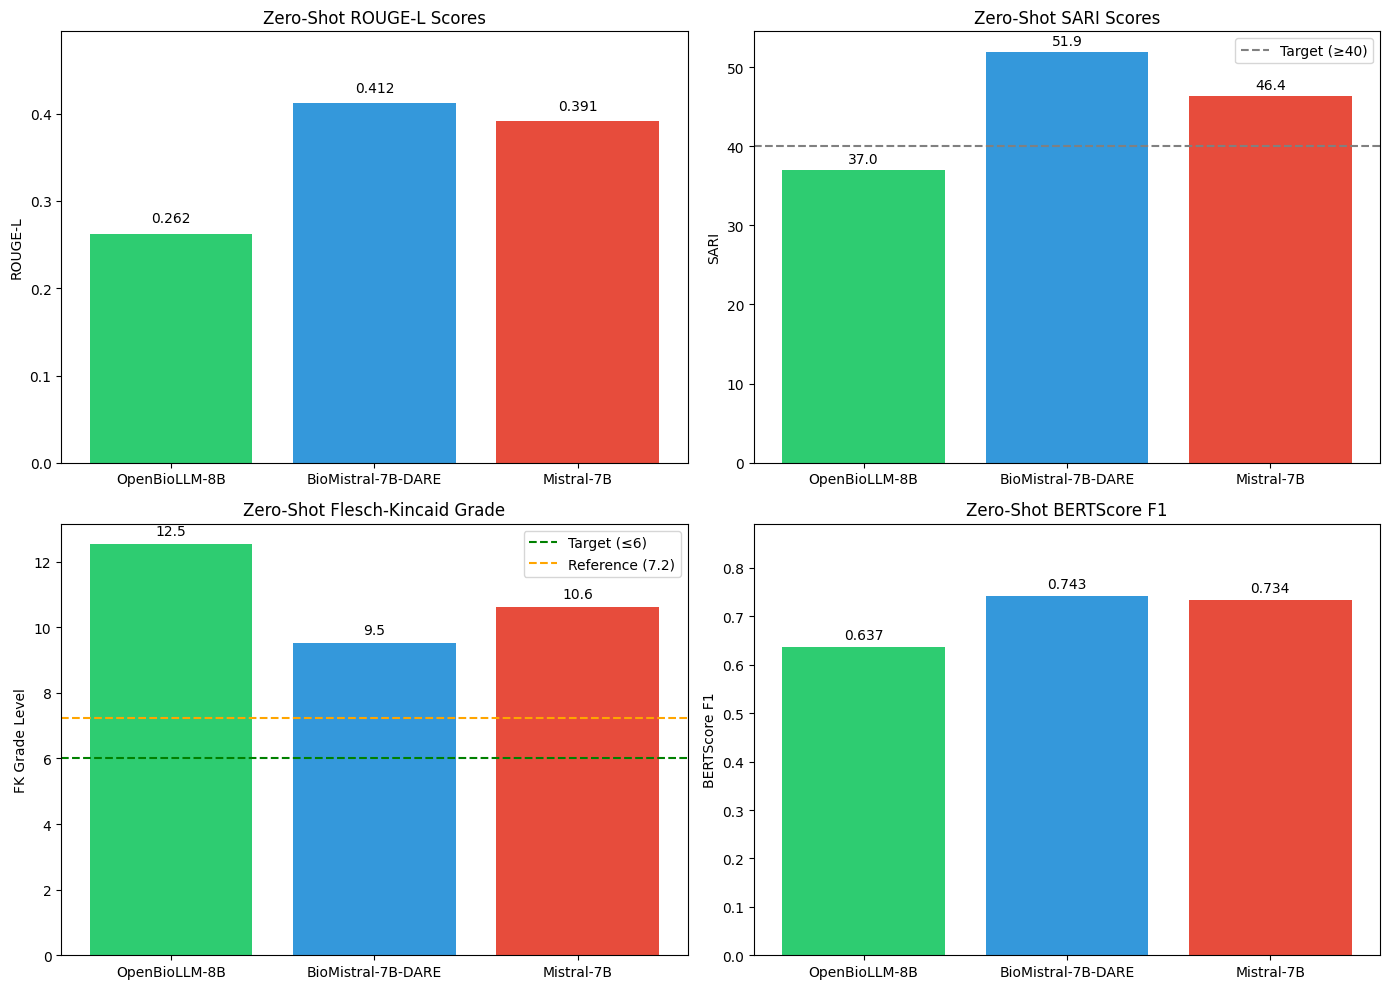

   ✓ Saved: /workspace/medisimplifier/results/figures/baseline_comparison.png

RESEARCH QUESTIONS ANALYSIS

📋 RQ1: Does medical pretraining help zero-shot simplification?
   Medical models avg ROUGE-L: 0.3372
   General models avg ROUGE-L: 0.3912
   Medical models avg SARI: 44.45
   General models avg SARI: 46.38
   → Answer: NO - General model outperforms medical models by 16.0% on ROUGE-L.

📋 RQ2: Which model is best at zero-shot?
   Ranking by ROUGE-L:
      1. BioMistral-7B-DARE: ROUGE-L=0.4120, SARI=51.91
      2. Mistral-7B: ROUGE-L=0.3912, SARI=46.38
      3. OpenBioLLM-8B: ROUGE-L=0.2623, SARI=36.98
   → Answer: BioMistral-7B-DARE (ROUGE-L=0.4120, SARI=51.91, FK=9.52)

📁 Saved: /workspace/medisimplifier/results/baseline/baseline_summary.md

CHAPTER 5 COMPLETE

📁 Generated Files:
   - instruction_dataset/chatml/ (ChatML format dataset)
   - instruction_dataset/mistral/ (Mistral format dataset)
   - baseline_metrics.csv
   - baseline_results.json
   - baseline_summary.md
   - fig

In [38]:
# =============================================================================
# SECTION 5.10: BASELINE RESULTS AGGREGATION
# =============================================================================

# Print section header for logging
print("=" * 70)
print("SECTION 5.10: BASELINE RESULTS AGGREGATION")
print("=" * 70)

# -----------------------------------------------------------------------------
# Create Results DataFrame
# -----------------------------------------------------------------------------

# Print summary header
print(f"\n📊 Baseline Results Summary:")

# Build list of result dictionaries for DataFrame creation
results_data = []
# Iterate through models in evaluation order
for model_name in BASELINE_EVAL_ORDER:
    # Check if results exist for this model
    if model_name in baseline_results:
        # Get metrics for current model
        metrics = baseline_results[model_name]
        # Get configuration for current model
        config = STUDENT_MODELS[model_name]
        # Append result dictionary with all relevant fields
        results_data.append({
            "Model": model_name,  # Model name
            "Type": config["type"],  # Medical or General
            "Format": config["prompt_format"],  # chatml or mistral
            "ROUGE-L": metrics["ROUGE-L"],  # ROUGE-L score
            "SARI": metrics["SARI"],  # SARI score
            "BERTScore-F1": metrics.get("BERTScore-F1", None),  # BERTScore (may be None)
            "FK-Grade": metrics["FK-Grade-Mean"],  # Mean Flesch-Kincaid grade
            "FK-Std": metrics["FK-Grade-Std"],  # FK standard deviation
            "Valid": metrics["valid_samples"],  # Count of valid predictions
            "Total": metrics["total_samples"],  # Total samples attempted
        })

# Create pandas DataFrame from results list
baseline_df = pd.DataFrame(results_data)
# Print DataFrame as formatted string
print(baseline_df.to_string(index=False))

# -----------------------------------------------------------------------------
# Save Results
# -----------------------------------------------------------------------------

# Print save status
print(f"\n📁 Saving results...")

# Define path for CSV file
csv_path = BASELINE_DIR / "baseline_metrics.csv"
# Save DataFrame to CSV
baseline_df.to_csv(csv_path, index=False)
# Print confirmation
print(f"   ✓ Saved: {csv_path}")

# Define path for JSON results file
json_path = BASELINE_DIR / "baseline_results.json"
# Save detailed results to JSON
with open(json_path, "w", encoding="utf-8") as f:
    json.dump({
        "results": baseline_results,  # Full metrics dictionary
        "reference_stats": REFERENCE_STATS,  # Reference statistics
        "timestamp": datetime.now().isoformat(),  # Save timestamp
    }, f, indent=2)
# Print confirmation
print(f"   ✓ Saved: {json_path}")

# -----------------------------------------------------------------------------
# Visualization
# -----------------------------------------------------------------------------

# Print visualization status
print(f"\n📈 Creating visualizations...")

# Create 2x2 subplot figure for metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Define colors for each model (green, blue, red)
colors = ["#2ecc71", "#3498db", "#e74c3c"]

# Plot 1: ROUGE-L scores (top-left)
ax = axes[0, 0]
# Create bar chart for ROUGE-L
bars = ax.bar(baseline_df["Model"], baseline_df["ROUGE-L"], color=colors)
# Set y-axis label
ax.set_ylabel("ROUGE-L")
# Set chart title
ax.set_title("Zero-Shot ROUGE-L Scores")
# Set y-axis limit with 20% headroom
ax.set_ylim(0, max(baseline_df["ROUGE-L"]) * 1.2)
# Add value labels on top of each bar
for bar, val in zip(bars, baseline_df["ROUGE-L"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f"{val:.3f}", ha="center", va="bottom", fontsize=10)

# Plot 2: SARI scores (top-right)
ax = axes[0, 1]
# Create bar chart for SARI
bars = ax.bar(baseline_df["Model"], baseline_df["SARI"], color=colors)
# Set y-axis label
ax.set_ylabel("SARI")
# Set chart title
ax.set_title("Zero-Shot SARI Scores")
# Add target line at SARI=40 (good simplification threshold)
ax.axhline(y=40, color="gray", linestyle="--", label="Target (≥40)")
# Add legend
ax.legend()
# Add value labels on top of each bar
for bar, val in zip(bars, baseline_df["SARI"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f"{val:.1f}", ha="center", va="bottom", fontsize=10)

# Plot 3: FK-Grade scores (bottom-left)
ax = axes[1, 0]
# Create bar chart for FK Grade
bars = ax.bar(baseline_df["Model"], baseline_df["FK-Grade"], color=colors)
# Set y-axis label
ax.set_ylabel("FK Grade Level")
# Set chart title
ax.set_title("Zero-Shot Flesch-Kincaid Grade")
# Add target line at FK=6 (6th grade target)
ax.axhline(y=6, color="green", linestyle="--", label="Target (≤6)")
# Add reference line showing ground truth mean FK
ax.axhline(y=REFERENCE_STATS["fk_mean"], color="orange", linestyle="--", 
           label=f"Reference ({REFERENCE_STATS['fk_mean']:.1f})")
# Add legend
ax.legend()
# Add value labels on top of each bar
for bar, val in zip(bars, baseline_df["FK-Grade"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
            f"{val:.1f}", ha="center", va="bottom", fontsize=10)

# Plot 4: BERTScore F1 (bottom-right)
ax = axes[1, 1]
# Handle potential None values in BERTScore by filling with 0
bertscore_vals = baseline_df["BERTScore-F1"].fillna(0)
# Create bar chart for BERTScore
bars = ax.bar(baseline_df["Model"], bertscore_vals, color=colors)
# Set y-axis label
ax.set_ylabel("BERTScore F1")
# Set chart title
ax.set_title("Zero-Shot BERTScore F1")
# Set y-axis limit with 20% headroom, minimum of 1 if all zeros
ax.set_ylim(0, max(bertscore_vals) * 1.2 if max(bertscore_vals) > 0 else 1)
# Add value labels on top of each bar (only if non-zero)
for bar, val in zip(bars, bertscore_vals):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f"{val:.3f}", ha="center", va="bottom", fontsize=10)

# Adjust layout to prevent overlapping
plt.tight_layout()
# Define save path for figure
fig_path = FIGURES_DIR / "baseline_comparison.png"
# Save figure to file
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
# Display figure
plt.show()
# Print confirmation
print(f"   ✓ Saved: {fig_path}")

# -----------------------------------------------------------------------------
# Research Questions Analysis
# -----------------------------------------------------------------------------

# Print RQ analysis header
print(f"\n" + "=" * 70)
print("RESEARCH QUESTIONS ANALYSIS")
print("=" * 70)

# Identify medical vs general models for comparison
# Get list of medical model names
medical_models = [m for m in BASELINE_EVAL_ORDER if STUDENT_MODELS[m]["type"] == "Medical"]
# Get list of general model names
general_models = [m for m in BASELINE_EVAL_ORDER if STUDENT_MODELS[m]["type"] == "General"]

# RQ1: Does medical pretraining help zero-shot simplification?
print(f"\n📋 RQ1: Does medical pretraining help zero-shot simplification?")

# Calculate average ROUGE-L for medical models
medical_avg_rouge = np.mean([baseline_results[m]["ROUGE-L"] for m in medical_models])
# Calculate average ROUGE-L for general models
general_avg_rouge = np.mean([baseline_results[m]["ROUGE-L"] for m in general_models])

# Calculate average SARI for medical models
medical_avg_sari = np.mean([baseline_results[m]["SARI"] for m in medical_models])
# Calculate average SARI for general models
general_avg_sari = np.mean([baseline_results[m]["SARI"] for m in general_models])

# Print comparison statistics
print(f"   Medical models avg ROUGE-L: {medical_avg_rouge:.4f}")
print(f"   General models avg ROUGE-L: {general_avg_rouge:.4f}")
print(f"   Medical models avg SARI: {medical_avg_sari:.2f}")
print(f"   General models avg SARI: {general_avg_sari:.2f}")

# Determine answer based on comparison
if medical_avg_rouge > general_avg_rouge:
    # Medical models performed better
    rq1_answer = f"YES - Medical pretraining helps. Medical models outperform general by {(medical_avg_rouge - general_avg_rouge)/general_avg_rouge*100:.1f}% on ROUGE-L."
else:
    # General models performed better
    rq1_answer = f"NO - General model outperforms medical models by {(general_avg_rouge - medical_avg_rouge)/medical_avg_rouge*100:.1f}% on ROUGE-L."
# Print RQ1 answer
print(f"   → Answer: {rq1_answer}")

# RQ2: Which model is best at zero-shot?
print(f"\n📋 RQ2: Which model is best at zero-shot?")

# Rank models by ROUGE-L score (descending)
ranked_models = sorted(
    baseline_results.keys(),  # All evaluated models
    key=lambda m: baseline_results[m]["ROUGE-L"],  # Sort by ROUGE-L
    reverse=True  # Highest first
)

# Get best model (first in ranked list)
best_model = ranked_models[0]
# Get metrics for best model
best_metrics = baseline_results[best_model]

# Print ranking
print(f"   Ranking by ROUGE-L:")
for i, model in enumerate(ranked_models, 1):
    print(f"      {i}. {model}: ROUGE-L={baseline_results[model]['ROUGE-L']:.4f}, SARI={baseline_results[model]['SARI']:.2f}")

# Format RQ2 answer
rq2_answer = f"{best_model} (ROUGE-L={best_metrics['ROUGE-L']:.4f}, SARI={best_metrics['SARI']:.2f}, FK={best_metrics['FK-Grade-Mean']:.2f})"
# Print RQ2 answer
print(f"   → Answer: {rq2_answer}")

# -----------------------------------------------------------------------------
# Generate Summary Report
# -----------------------------------------------------------------------------

# Create markdown summary report
summary_md = f"""# MediSimplifier Baseline Summary

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Zero-Shot Baseline Results

| Model | Type | ROUGE-L | SARI | BERTScore | FK-Grade |
|-------|------|---------|------|-----------|----------|
"""

# Add row for each model
for _, row in baseline_df.iterrows():
    # Format BERTScore (handle None)
    bertscore = f"{row['BERTScore-F1']:.4f}" if pd.notna(row['BERTScore-F1']) else "N/A"
    # Add table row
    summary_md += f"| {row['Model']} | {row['Type']} | {row['ROUGE-L']:.4f} | {row['SARI']:.2f} | {bertscore} | {row['FK-Grade']:.2f} |\n"

# Add reference statistics and RQ answers
summary_md += f"""
## Reference Statistics (Ground Truth)

- FK Grade Mean: {REFERENCE_STATS['fk_mean']:.2f}
- FK Grade Std: {REFERENCE_STATS['fk_std']:.2f}
- Total Samples: {REFERENCE_STATS['n_samples']}

## Research Questions

### RQ1: Does medical pretraining help zero-shot simplification?

{rq1_answer}

### RQ2: Which model is best at zero-shot?

{rq2_answer}

## Key Findings

1. Best zero-shot model: **{best_model}**
2. All models produce text above target FK grade (≤6)
3. SARI scores indicate {'adequate' if best_metrics['SARI'] >= 40 else 'inadequate'} simplification quality

## Next Steps

- Proceed to Chapter 6 for LoRA fine-tuning
- Use these baselines to measure improvement from training
"""

# Define save path for summary markdown
summary_path = BASELINE_DIR / "baseline_summary.md"
# Save summary to file
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_md)
# Print confirmation
print(f"\n📁 Saved: {summary_path}")

# -----------------------------------------------------------------------------
# Final Summary
# -----------------------------------------------------------------------------

# Print chapter completion header
print(f"\n" + "=" * 70)
print("CHAPTER 5 COMPLETE")
print("=" * 70)

# List all generated files
print(f"\n📁 Generated Files:")
print(f"   - instruction_dataset/chatml/ (ChatML format dataset)")
print(f"   - instruction_dataset/mistral/ (Mistral format dataset)")
print(f"   - baseline_metrics.csv")
print(f"   - baseline_results.json")
print(f"   - baseline_summary.md")
print(f"   - figures/baseline_comparison.png")
# List individual model prediction files
for model_name in BASELINE_EVAL_ORDER:
    print(f"   - baseline_{model_name.lower().replace('-', '_')}.json")

# Print summary of best model
print(f"\n📊 Baseline Summary:")
print(f"   Best Zero-Shot: {best_model}")
print(f"   - ROUGE-L: {best_metrics['ROUGE-L']:.4f}")
print(f"   - SARI: {best_metrics['SARI']:.2f}")
print(f"   - FK-Grade: {best_metrics['FK-Grade-Mean']:.2f}")

# Print next steps
print(f"\n➡️ Proceed to Chapter 6 for LoRA Fine-Tuning")